This notebook contains code for running basic time series analysis on the energy generated data.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.dates import (YEARLY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)
import datetime   # package that helps manipulate dates

#for decomposition:
from statsmodels.tsa.seasonal import seasonal_decompose

# used for autocorrelation
import statsmodels.api as sm

# measuring MAE
from sklearn.metrics import mean_absolute_error

In [4]:
# increase figure size
plt.rcParams['figure.figsize'] = [12, 8]

In [5]:
#Importing data and cleaning to make a nice df with 2 columns

# import data (file and path are not from github, just downloaded because git stuff wasn't completed yet)
df = pd.read_csv("./nrg_gen_full_daily.csv")

#renaming the columns we want to actually keep 
df.rename(columns={
        'Data Dica': 'date', 
        'Selecione Tipo de GE Simp 4': 'energy_generated'
    }, inplace=True)

#Creating list of all columns we want to delete (gotten in separate cell using df.columns)
badcols = ['Data Escala de Tempo 1 GE Simp 4',
       'cod_aneel (tb_referenciacegusina (Usina))',
       'cod_nucleoaneel (tb_referenciacegusina (Usina))',
       'dsc_estado', 'id_subsistema', 'nom_tipousinasite', 'nom_usina2',
       'Período Exibido GE']
#actually deleting those unnecessary columns
for col in badcols:
    del df[col]
    
# turn "date" into a quantifiable object
df["date"] = pd.to_datetime(df["date"],format = '%d/%m/%Y')  


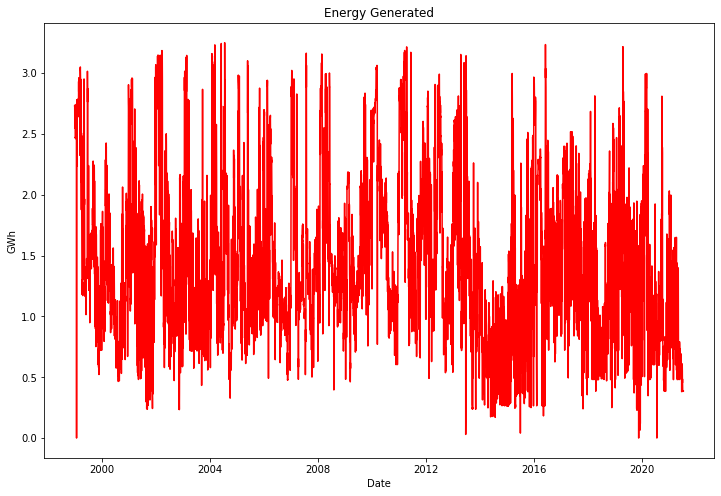

In [6]:
#plotting energy generated over full time period
plt.plot(df.date[:], df.energy_generated[:], 'r')   
plt.title('Energy Generated')
# Units not in GWh
plt.ylabel('GWh');
plt.xlabel('Date');
plt.show();

In the next cell we are doing the basic time series decomposition that was demonstrated in class

the results are not fruitful

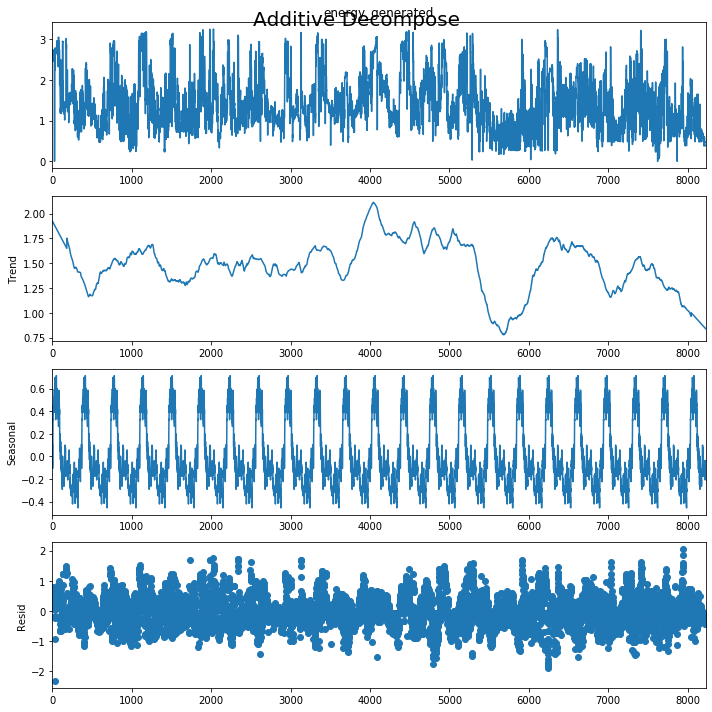

In [7]:


# Must choose a period for the decomposition; here choosing an annual one
# Multiplicative Decomposition:  Returns seasonal, trend, and resid attributes
result_mul = seasonal_decompose(df['energy_generated'] + 0.0001, model='multiplicative', extrapolate_trend='freq', period=365)

# Additive Decomposition
result_add = seasonal_decompose(df['energy_generated'], model='additive', extrapolate_trend='freq', period=365)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
#result_mul.plot().suptitle('Multiplicative Decompose', fontsize=20)
result_add.plot().suptitle('Additive Decompose', fontsize=20)
plt.savefig('foo.png')
plt.show()

Checking autocorrelation

In [8]:
#calculate autocorrelations
# nlags is how many lags to compute, presumably approximately evenly spaced
sm.tsa.acf(df['energy_generated'], nlags = 121)
#sm.tsa.acf(df['energy_generated'], nlags = 10)


/Users/cameronthieme/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


array([ 1.        ,  0.86223697,  0.79042404,  0.75005731,  0.7120251 ,
        0.67781396,  0.66568687,  0.6776603 ,  0.60976593,  0.56740018,
        0.54629607,  0.53022956,  0.51753356,  0.51929838,  0.54341633,
        0.49684937,  0.46888431,  0.45779927,  0.4454274 ,  0.43638366,
        0.44405905,  0.46710721,  0.41971969,  0.39252541,  0.38046532,
        0.37015741,  0.36391043,  0.3740501 ,  0.40001022,  0.35818833,
        0.33680272,  0.33110715,  0.33154818,  0.32836861,  0.33858557,
        0.36579865,  0.32662368,  0.30675335,  0.30308873,  0.30104785,
        0.30036096,  0.31461467,  0.34522604,  0.308588  ,  0.28945689,
        0.28605769,  0.28222789,  0.27857836,  0.28972291,  0.31742112,
        0.27660096,  0.25741612,  0.25252601,  0.24977258,  0.24314614,
        0.25051781,  0.27497229,  0.23483463,  0.21196983,  0.20598822,
        0.20040583,  0.19361299,  0.19991515,  0.22303528,  0.18561606,
        0.16858707,  0.16427129,  0.15927835,  0.15206509,  0.15

From autocorrelation output above, we see that the autocorrelation is weak (just gets weaker and weaker as time goes back), and there doesn't seem to be any seasonality.  

The following code checks that lack of seasonality

Maybe there is very slight seasonality, with period 7*121?  I should recheck the basic stuff with that kind of period

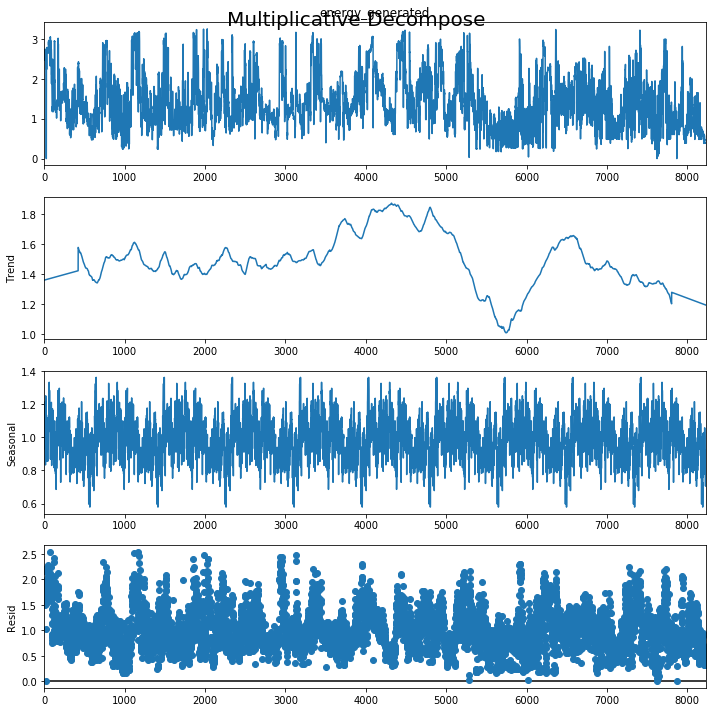

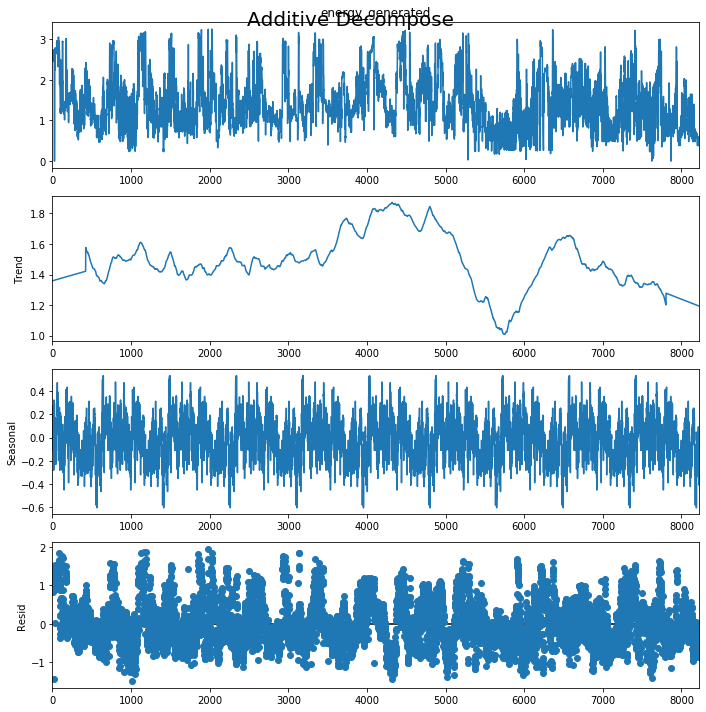

In [9]:
# Must choose a period for the decomposition; here choosing an annual one
# Multiplicative Decomposition:  Returns seasonal, trend, and resid attributes
per = 7*121

result_mul = seasonal_decompose(df['energy_generated'] + 0.0001, model='multiplicative', extrapolate_trend='freq', period=per)

# Additive Decomposition
result_add = seasonal_decompose(df['energy_generated'], model='additive', extrapolate_trend='freq', period=per)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=20)
result_add.plot().suptitle('Additive Decompose', fontsize=20)
plt.show()

Didn't work any better really... but that's pretty expected

Let's do some windowing, and see if we can extract better patterns from smaller subsets

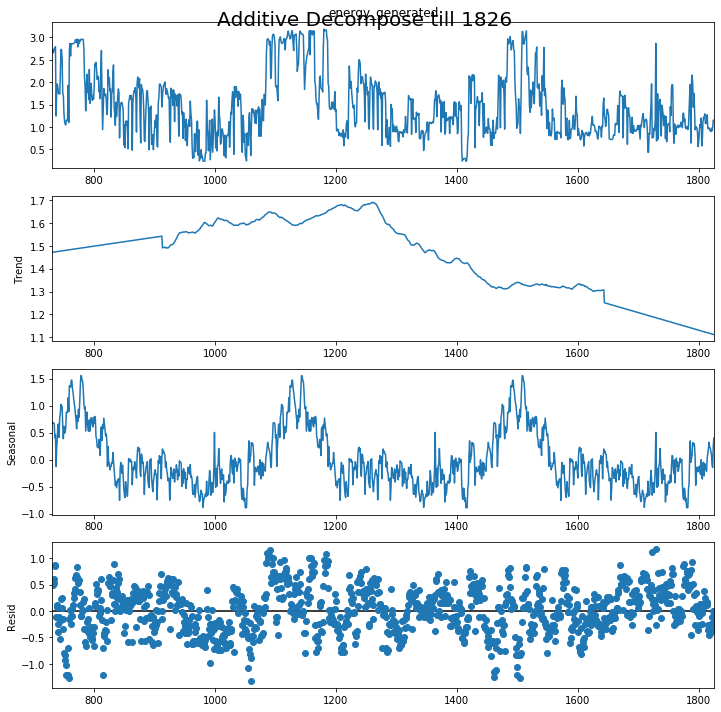

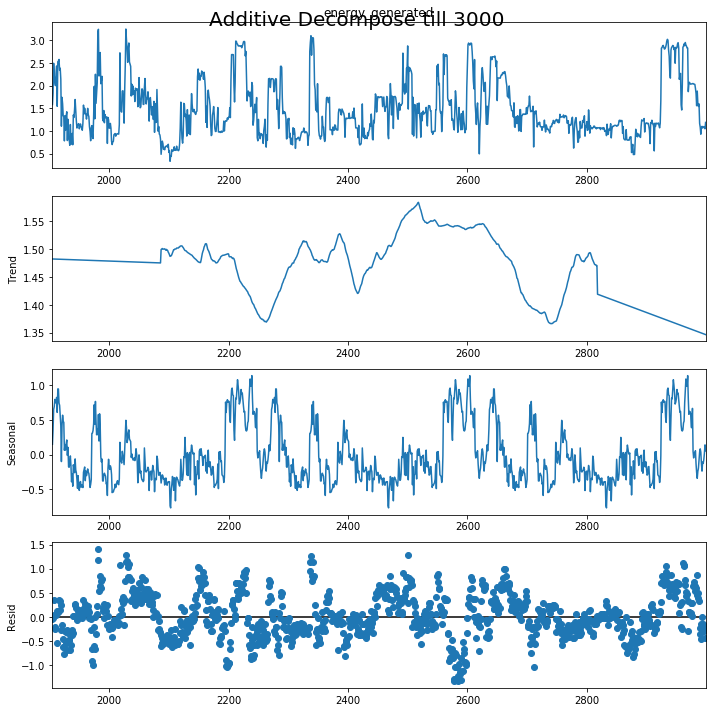

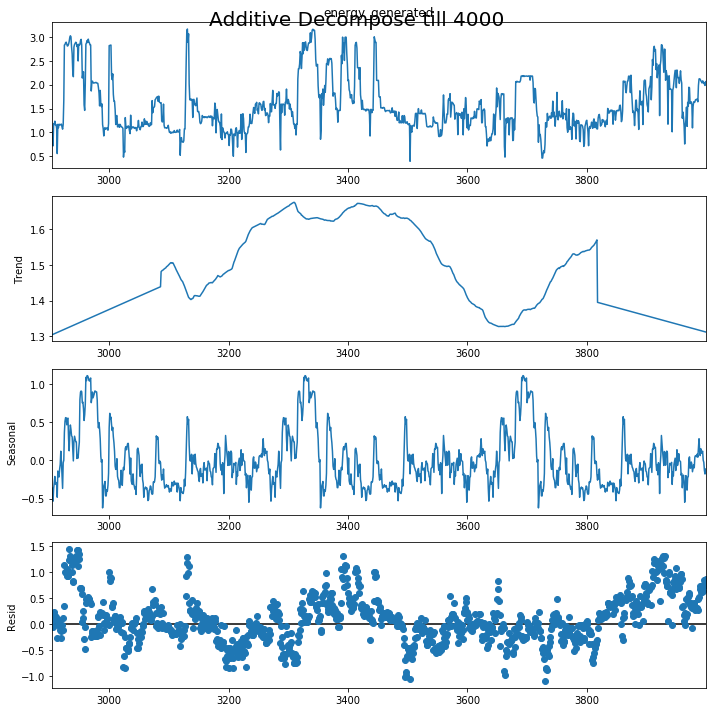

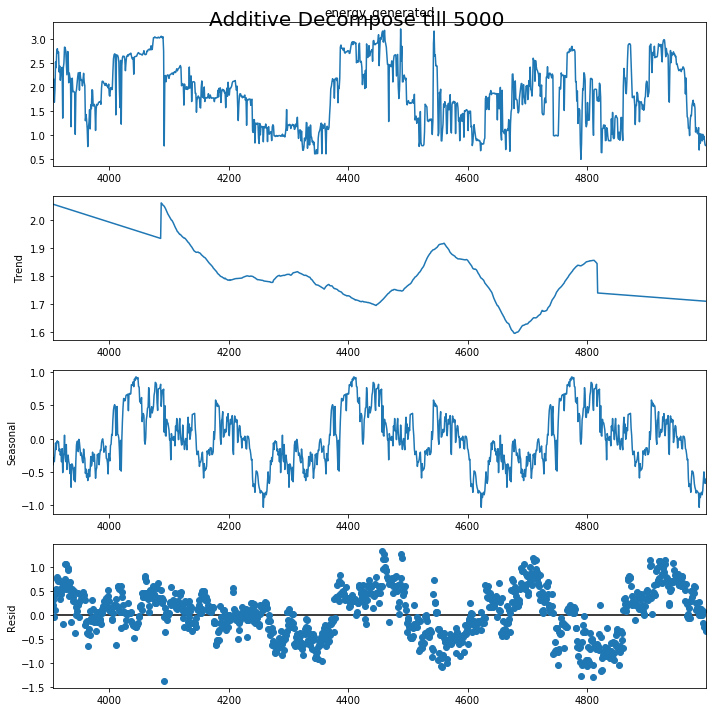

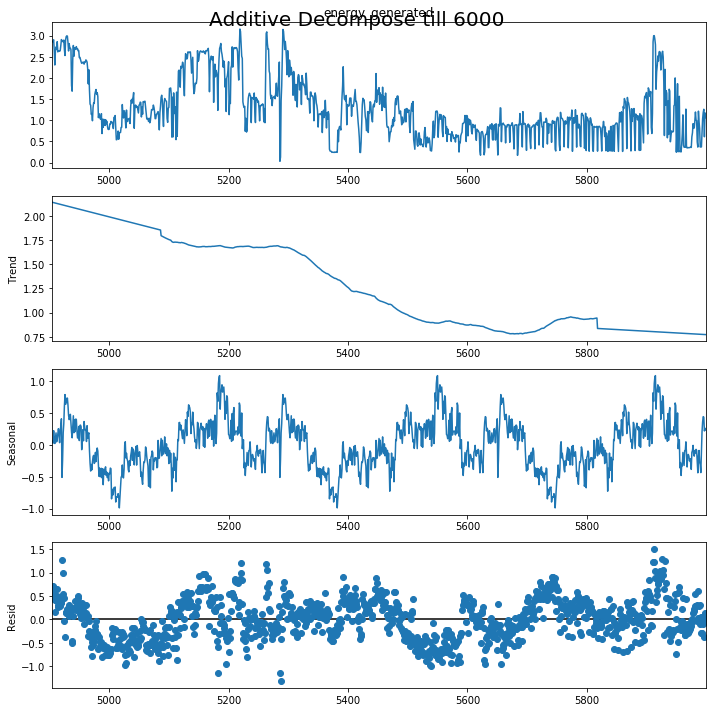

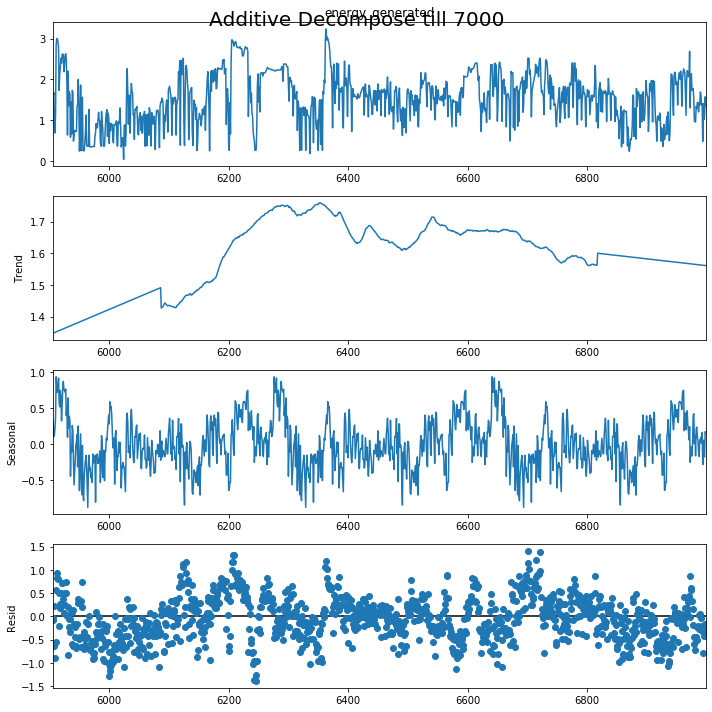

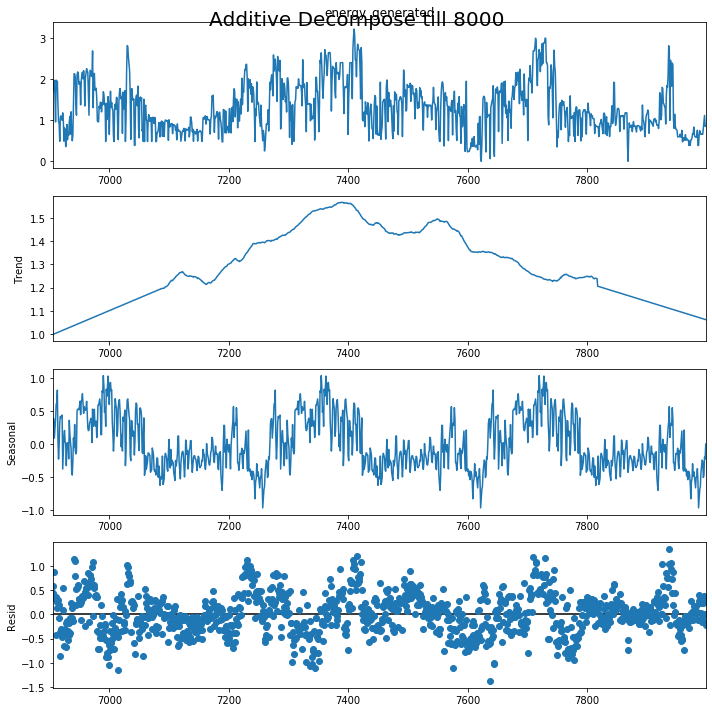

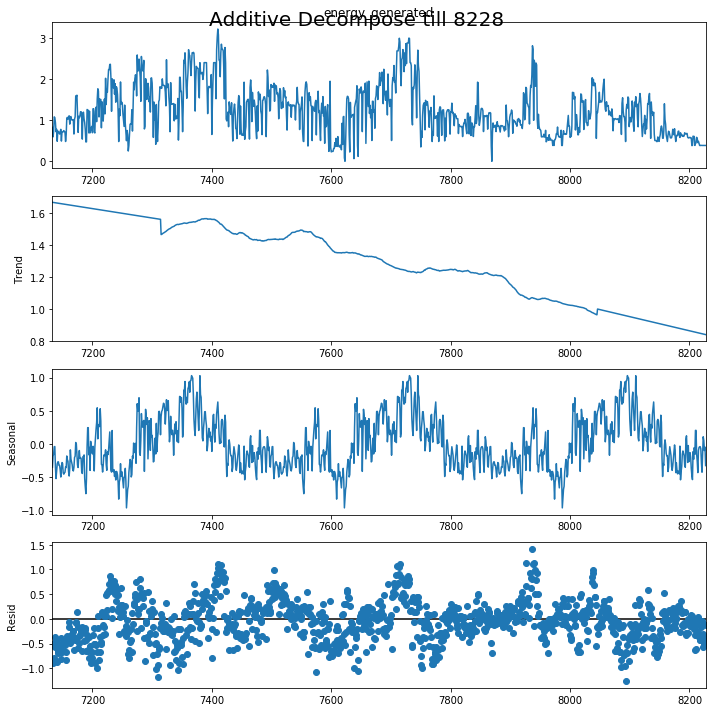

In [10]:
# Multiplicative Decomposition:  Returns seasonal, trend, and resid attributes
#Choose periodicity of seasonality (currently 365 days naively)
per = 365
# how long of a window to examine over
win_length = 365*3
# ending point (should figure out how to put in dates here more directly at some point)
# these are pretty randomly chosen, should also see if I can pick some better windows by eye or by historical/weather events
end_points = [1826, 3000, 4000, 5000, 6000, 7000, 8000, len(df)]

for ends in end_points:
    
    #result_mul = seasonal_decompose(df.iloc[(ends-win_length):ends,1] + 0.0001, model='multiplicative', extrapolate_trend='freq', period=per)

    # Additive Decomposition
    result_add = seasonal_decompose(df.iloc[(ends-win_length):ends,1], model='additive', extrapolate_trend='freq', period=per)

    # Plot
    plt.rcParams.update({'figure.figsize': (10,10)})
    #result_mul.plot().suptitle('Multiplicative Decompose till %i' %ends, fontsize=20)
    result_add.plot().suptitle('Additive Decompose till %i' %ends, fontsize=20)
    plt.savefig('foo.png')
    plt.show()

For this next segment, I want to run through some extremely naive prediction methods.  Basically, gonna (2) predict things with regressions using season as dummy variables, (1) seasonal naive, and (3) slightly less naive seasonal method by averaging of that day in history.

In [95]:
# create train/test split 

# identify how many days in advance we would like to predict
pred_length = 30

# New data frame excluding the days that we want to predict
train = df.iloc[:len(df)-pred_length,1]
# The actual data that we aim to reproduce
test = df.iloc[len(df)-pred_length:, 1]




Up first is seasonal naive method

Description: https://otexts.com/fpp2/simple-methods.html

Implementation found here: https://pawarbi.github.io/blog/forecasting/r/python/rpy2/altair/fbprophet/ensemble_forecast/uncertainty/simulation/2020/04/21/timeseries-part2.html#Seasonal-Naive

Seems above place is going through the same book and implementing the methods in python

Update: that implementation seems wrong (or I'm misunderstanding the inputs) so I'm gonna just do my own thing

In [11]:
# Function to do basic seasonal naive method

def seasonal_naive(time_data, pred_length):
    '''
    This function implements the seasonal naive method for daily input data
    not a robust function, basically made for our problem with the energy generation
    Basically for each day we want to predict, we just guess the same output as last year
    Also checks MAE of this prediction
    
    Packages Required:
    >>> from sklearn.metrics import mean_absolute_error
    
    Returns 
        preds: an array of the predicted values
        pred_mae: Mean absolute error of the predictions
    
    Inputs:
        time_data: Pand series
            all the relevant data, including that which we want to predict
        pred_length: integer
            number of days we would like to predict
    '''
    
    # New series excluding the days that we want to predict
    train = time_data[:-pred_length]
    # The actual data that we aim to reproduce
    test = time_data[-pred_length:]
    
    # select the predicted values
    preds = train[-365:-365+ pred_length]
    
    #compute MAE
    mae = mean_absolute_error(preds,test)
    
    return preds, mae

In [12]:
# checking results of seasonal naive method
seasonal_naive(df['energy_generated'],14)

(7849    0.969537
 7850    1.097529
 7851    1.276614
 7852    1.288772
 7853    1.280358
 7854    1.229522
 7855    0.723050
 7856    1.105708
 7857    1.107607
 7858    1.087932
 7859    1.095004
 7860    1.114846
 7861    1.110785
 7862    0.782205
 Name: energy_generated, dtype: float64,
 0.6898772142857144)

Seasonal naive method has some serious errors, so let's try something a little bit (but not much) more sophisticated: guess each day is the average of power output on that day in previous years

In [13]:
def day_mean_forecast(df, pred_length):
    '''
    Makes a forecast by guessing that output of that day will be the average of the output on same day days in previous years
    Also checks MAE of this prediction
    
    Packages Required:
    from sklearn.metrics import mean_absolute_error
    pandas
    numpy
    
    Returns 
        preds: an array of the predicted values
        pred_mae: Mean absolute error of the predictions
    
    Inputs:
        df: 2xn Pandas dataframe
            first column is dates (Y-m-d) (must be labelled 'date' at this point)
            second column is relevant time series data
        pred_length: integer
            number of days we would like to predict
    '''
    
    # adding columns of which month and day-of-month for each entry to df
    df['month'] = pd.DatetimeIndex(df['date']).month
    df['day'] = pd.DatetimeIndex(df['date']).day
    
    
    # New data frame excluding the days that we want to predict
    train = df.iloc[:-pred_length,:]
    # The actual data that we aim to reproduce
    test = df.iloc[-pred_length:, :]
    
    #setup for predicted values
    preds = test.copy()
    
    # predicted energy_generated is average
    for n in preds.index:
        this_date_in = train[(train['month'] == preds['month'][n]) & (train['day'] == preds['day'][n])]
        preds['energy_generated'][n] = np.mean(this_date_in['energy_generated'])
        
    
    #compute MAE
    mae = mean_absolute_error(preds['energy_generated'],test['energy_generated'])
    
    return preds, mae

In [15]:
day_mean_forecast(df,30)

/Users/cameronthieme/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(           date  energy_generated  month  day
 8198 2021-06-13          1.484083      6   13
 8199 2021-06-14          1.414925      6   14
 8200 2021-06-15          1.320325      6   15
 8201 2021-06-16          1.416176      6   16
 8202 2021-06-17          1.390597      6   17
 8203 2021-06-18          1.294847      6   18
 8204 2021-06-19          1.310670      6   19
 8205 2021-06-20          1.329161      6   20
 8206 2021-06-21          1.380509      6   21
 8207 2021-06-22          1.409854      6   22
 8208 2021-06-23          1.210703      6   23
 8209 2021-06-24          1.382402      6   24
 8210 2021-06-25          1.509857      6   25
 8211 2021-06-26          1.470218      6   26
 8212 2021-06-27          1.492625      6   27
 8213 2021-06-28          1.380294      6   28
 8214 2021-06-29          1.392561      6   29
 8215 2021-06-30          1.310965      6   30
 8216 2021-07-01          1.366306      7    1
 8217 2021-07-02          1.372697      7    2
 8218 2021-07